# Remarks on dynamics of epidemiological models: Common features and an almost-linear trade-off between start and duration of distancing mandates
## Mahdiar Sadeghi
## Objective
This notebook is dedicated to understand how social distancing will effect the spread of an epidemic.
## Setup

In [1]:
using DifferentialEquations, Plots, Plots.PlotMeasures, LaTeXStrings

## Utility functions

In [2]:
# change plot fonts
bplot(p, s) = plot!(p, titlefont=font(s, "Times"), xguidefontsize=s-4
    , ytickfont=font(s-4, "Times"), margin=8mm, yguidefontsize=s-4
    , xtickfont = font(s-4, "Times"), legendfont = font(s-4, "Times"))

# this function will generate a T period of social distancing at time t0
sinput(t, ts, td) = if (t-ts<0 || t-ts-td>0) 0 else 1 end

# this function will generate a periodic input with basic properties
# r the ratio between on and off state should be \in [0,1]
# T period of the input
# t0 start time of the policy
pinput(t, r, T, t0) = if t-t0<0 0 
    elseif r<=0 0 elseif r>=1 1
    elseif T<=0 0
    else 1-sign(floor(rem((t-t0)/T,1)/r)) end

# this function will generate a periodic input with a single pulse
# r the ratio between on and off state should be \in [0,1]
# T period of the input
# ts start time of the strict social distancing policy
# td duration of the social distancing
spinput(t, ts, td, r, T) = if (t-ts>0 && t-ts-td<0) 1 
    elseif r<=0 0 elseif r>=1 1
    elseif T<=0 0
    else 1-sign(floor(rem(t/T,1)/r)) end

spinput (generic function with 1 method)

# $SIR$ Model

## Periodic input

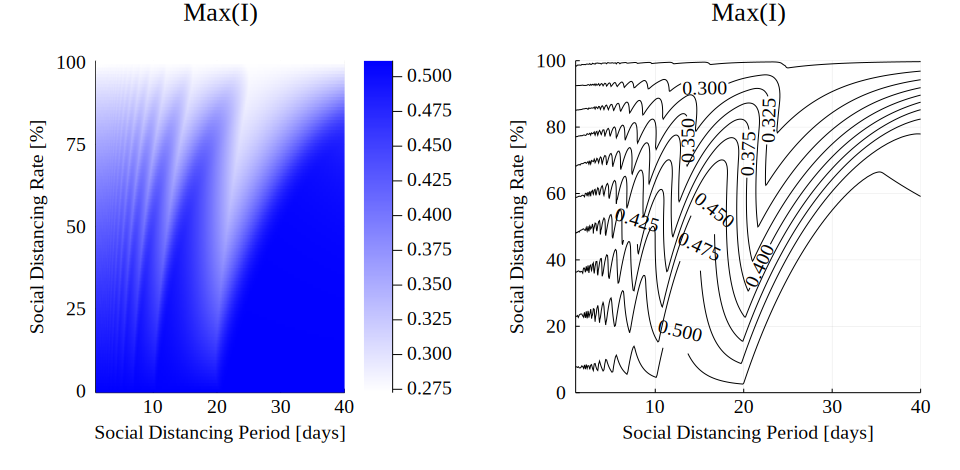

In [3]:
# SIR model description
function SIR1(dx,x,p,t)
    b, db, g, r, T, t0 = p
    u = b - db.*pinput(t, r, T, t0)
    dx[1] = - u*x[1]*x[2]
    dx[2] = u*x[1]*x[2] - g*x[2] 
    dx[3] = g*x[2] 
end

# define key parameters
mainT, main0, mainr = [10.0, 0.0, 0.5]
gamma, beta, betad = [0.09, 0.5, 0.25]
bdiff = beta-betad
tspan = (0.0, 1e3)
u0 = [1-1e-3, 1e-3, 0.]
p  = [beta, bdiff, gamma, 0.0, mainT, main0]

# ode solver
alg = BS3()

Trng = 1:1e-1:40
rrng = 0:1e-2:1
data = zeros(size(rrng,1), size(Trng,1))

for i = 1:size(rrng,1)
    for j = 1:size(Trng,1)
        # solve the ode problem
        p[4:5] = [rrng[i], Trng[j]]
        prob = ODEProblem(SIR1, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        # save the maximum value of the infected peak
        data[i,j] = maximum(sol[2,:])
    end
end

p1 = heatmap(Trng, 100*rrng, data,c=ColorGradient([:white, :blue]),
    ylabel="Social Distancing Rate [%]", xlabel="Social Distancing Period [days]",
    title="Max(I)")
p1 = bplot(p1, 16)
savefig(p1, "figures/SIRp_heatmap.pdf")
p2 = contour(Trng, 100*rrng, data, ylabel="Social Distancing Rate [%]"
    , title="Max(I)", xlabel="Social Distancing Period [days]"
    , contour_labels = true, linewidth=1, colorbar = false, c=:black
    , levels=[0.275, 0.30, 0.325, 0.35, 0.375, 0.40, 0.425, 0.45, 0.475, 0.50])
p2 = bplot(p2, 16)
savefig(p2, "figures/SIRp_contour.pdf")

fig = plot(p1, p2, layout=(1,2), size=(960,470))

# Periodic Input with Single Pulse

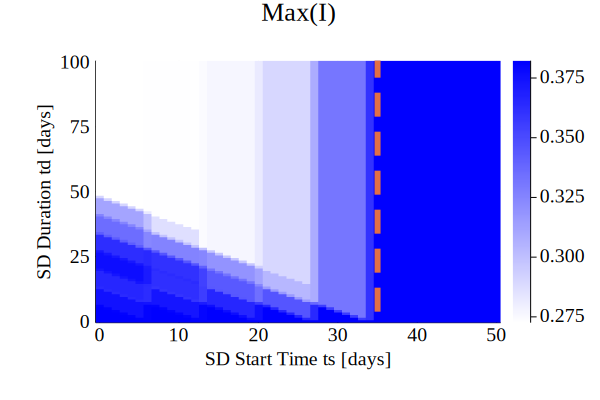

In [4]:
# SIR model description
function SIR2(dx,x,p,t)
    b, db, g, ts, td, r, T = p
    u = b - db.*spinput(t, ts, td, r, T)
    dx[1] = - u*x[1]*x[2]
    dx[2] = u*x[1]*x[2] - g*x[2] 
    dx[3] = g*x[2] 
end

# define key parameters
mainT, mainr, ts, td = [7., 5/7, 0, 5]
gamma, beta, betad = [0.09, 0.5, 0.25]
bdiff = beta-betad
tspan = (0.0, 1e3)
u0 = [1-1e-3, 1e-3, 0.]
p  = [beta, bdiff, gamma, ts, td, mainr, mainT]

# range of the quarantine starting time and duration
Trng = 0:100 
trng = 0:50
data = zeros(size(Trng,1), size(trng,1))
time = data

# ode solver
alg = BS3()

p[4:5] = [0, 0]
prob  = ODEProblem(SIR2, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])] # time of the peak

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(SIR2, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p1 = heatmap(trng, Trng, data,c=ColorGradient([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p1 = plot!(p1, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=6, legend=:false)
p1 = bplot(p1, 16)
savefig(p1, "figures/SIRsp_heatmap.pdf")
p1

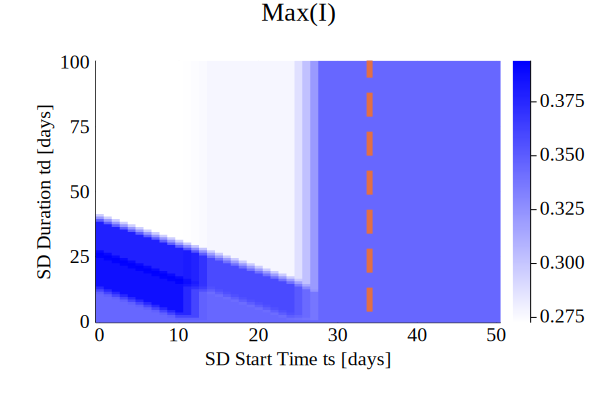

In [5]:
# define key parameters
mainT, mainr, ts, td = [14., 5/7, 0, 5]
p  = [beta, bdiff, gamma, ts, td, mainr, mainT]

# range of the quarantine starting time and duration
Trng = 0:100 
trng = 0:50
data = zeros(size(Trng,1), size(trng,1))
time = data

# ode solver
alg = BS3()

p[4:5] = [0, 0]
prob  = ODEProblem(SIR2, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])] # time of the peak

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(SIR2, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p2 = heatmap(trng, Trng, data,c=ColorGradient([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p2 = plot!(p2, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=6, legend=:false)
p2 = bplot(p2, 16)
savefig(p2, "figures/SIRsp_heatmap2.pdf")
p2

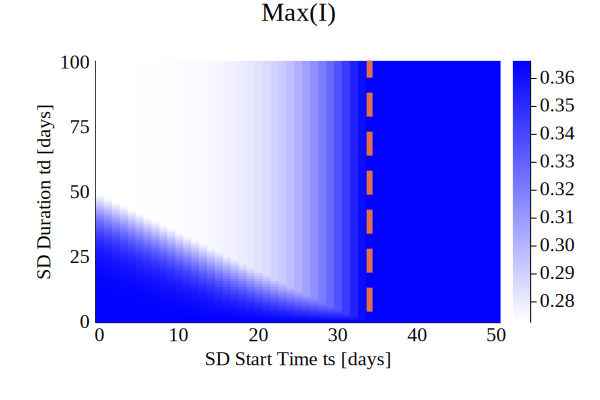

In [6]:
# define key parameters
mainT, mainr, ts, td = [1, 5/7, 0, 5]
p  = [beta, bdiff, gamma, ts, td, mainr, mainT]

# range of the quarantine starting time and duration
Trng = 0:100 
trng = 0:50
data = zeros(size(Trng,1), size(trng,1))
time = data

# ode solver
alg = BS3()

p[4:5] = [0, 0]
prob  = ODEProblem(SIR2, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])] # time of the peak

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(SIR2, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p2 = heatmap(trng, Trng, data,c=ColorGradient([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p2 = plot!(p2, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=6, legend=:false)
p2 = bplot(p2, 16)
savefig(p2, "figures/SIRsp_heatmap3.pdf")
p2

# Mild SD with Single Pulse

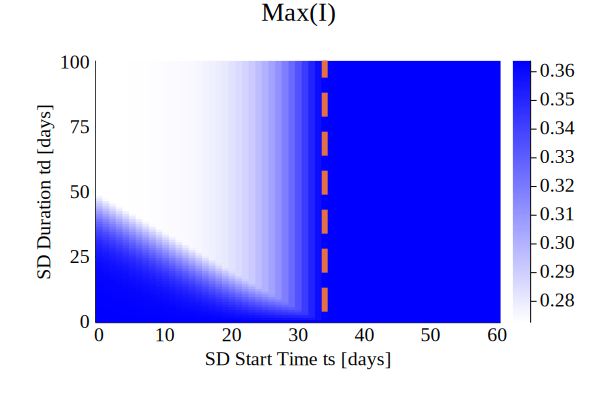

In [7]:
# model description
function SIR(dx,x,p,t)
    b, db, g, ts, td = p
    u = b - db.*sinput(t, ts, td)
    dx[1] = -u*x[1]*x[2]
    dx[2] = u*x[1]*x[2] - g*x[2]
    dx[3] = g*x[2]
end

beta  = 0.5*2/7+0.25*5/7
bdiff = beta-0.25
gamma = 0.09

# define initial values
u0 = [1-1e-3, 1e-3, 0.]
p  = [beta, bdiff, gamma, 10, 40]

# ode solver
alg = BS3()

# range of the quarantine starting time and duration
Trng = 0:100
trng = 0:60
data = zeros(size(Trng,1), size(trng,1))
time = data

# define initial values
u0 = [1-1e-3, 1e-3, 0.]
tspan = (0.0, 1e3)

p[4:5] = [0, 0]
prob  = ODEProblem(SIR, u0, tspan, p)
sol   = solve(prob, alg, reltol=1e-8, abstol=1e-8)
timen = sol.t[argmax(sol[2,:])]

for i = 1:size(Trng,1)
    for j = 1:size(trng,1)
        # solve the ode problem
        p[4:5] = [trng[j], Trng[i]]
        prob = ODEProblem(SIR, u0, tspan, p)
        sol  = solve(prob, alg, reltol=1e-8, abstol=1e-8)
        data[i,j] = maximum(sol[2,:])
    end
end

p = heatmap(trng, Trng, data,c=ColorGradient([:white, :blue]),
    xlabel="SD Start Time ts [days]", ylabel="SD Duration td [days]",
    title="Max(I)")
p = plot!(p, [Int(round(timen))], seriestype="vline", line=:dash, linewidth=6, legend=:false)
p = bplot(p, 16)
savefig(p, "figures/SIRmild_heatmap.pdf")
p

# Provenance

In [8]:
using Dates
Dates.format(now(), "U/d HH:MM")  

"June/17 09:40"